In [154]:
# !pip install mlxtend

In [155]:
# importation les bibliothèques necessaires
import pandas as pd
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# 1. Chargement et Préparation des Données

In [157]:
# Chargement des données
df = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
print("Dimensions:", df.shape)
df.head()

Dimensions: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [158]:
# Suppression de la colonne 'id' qui n’est pas utile pour l’analyse
df.drop(columns='id', inplace=True)

# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne :\n", df.isnull().sum())

# Traitement des valeurs manquantes dans 'bmi' par la moyenne
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
# Vérification après traitement
print("\nValeurs manquantes après traitement :\n", df.isnull().sum())

Valeurs manquantes par colonne :
 gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Valeurs manquantes après traitement :
 gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


C:\Users\dell\AppData\Local\Temp\ipykernel_16668\720994606.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


In [159]:
# Discrétisation des variables continues avec des seuils cliniquement pertinents
# Âge : basé sur des groupes à risque (inspiré de la littérature médicale)
df['age_bin'] = pd.cut(df['age'], bins=[0, 18, 35, 55, 75, 100],
                      labels=['child', 'young_adult', 'adult', 'senior', 'elderly'])

# Glucose moyen : seuils basés sur les critères du diabète (<100, 100-125, >125 mg/dL)
df['glucose_bin'] = pd.cut(df['avg_glucose_level'], bins=[0, 100, 125, 200, 300],
                          labels=['normal', 'pre_diabetes', 'diabetes', 'very_high'])

# BMI : seuils de l'OMS
df['bmi_bin'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100],
                      labels=['underweight', 'normal', 'overweight', 'obese'])

In [160]:
# Encodage one-hot des variables catégorielles et binaires
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 
            'age_bin', 'glucose_bin', 'bmi_bin']
df_encoded = pd.get_dummies(df[cat_cols], prefix=cat_cols, prefix_sep='=')

# Ajouter les colonnes binaires existantes
df_encoded = pd.concat([df[['hypertension', 'heart_disease', 'stroke']], df_encoded], axis=1)

# Convertir les colonnes binaires en format 'colonne=valeur' pour Apriori
for col in ['hypertension', 'heart_disease', 'stroke']:
    df_encoded[f'{col}=1'] = df_encoded[col].astype(bool)
    df_encoded[f'{col}=0'] = ~df_encoded[col].astype(bool)
    df_encoded = df_encoded.drop(col, axis=1)

# Supprimer les colonnes continues originales
df_final = df_encoded
print("\nJeu de données préparé :")
print(df_final.head())



Jeu de données préparé :
   gender=Female  gender=Male  gender=Other  ever_married=No  \
0          False         True         False            False   
1           True        False         False            False   
2          False         True         False            False   
3           True        False         False            False   
4           True        False         False            False   

   ever_married=Yes  work_type=Govt_job  work_type=Never_worked  \
0              True               False                   False   
1              True               False                   False   
2              True               False                   False   
3              True               False                   False   
4              True               False                   False   

   work_type=Private  work_type=Self-employed  work_type=children  ...  \
0               True                    False               False  ...   
1              False                  

In [161]:

df_final.head()

,gender=Female,gender=Male,gender=Other,ever_married=No,ever_married=Yes,work_type=Govt_job,work_type=Never_worked,work_type=Private,work_type=Self-employed,work_type=children,...,bmi_bin=underweight,bmi_bin=normal,bmi_bin=overweight,bmi_bin=obese,hypertension=1,hypertension=0,heart_disease=1,heart_disease=0,stroke=1,stroke=0
0,False,True,False,False,True,False,False,True,False,False,...,False,False,False,True,False,True,True,False,True,False
1,True,False,False,False,True,False,False,False,True,False,...,False,False,True,False,False,True,False,True,True,False
2,False,True,False,False,True,False,False,True,False,False,...,False,False,False,True,False,True,True,False,True,False
3,True,False,False,False,True,False,False,True,False,False,...,False,False,False,True,False,True,False,True,True,False
4,True,False,False,False,True,False,False,False,True,False,...,False,True,False,False,True,False,False,True,True,False


# 2. Transformation pour Apriori

In [163]:
# Le DataFrame est déjà binaire (0/1), prêt pour Apriori
df_apriori = df_final.astype(bool)


In [164]:

df_apriori.head()

,gender=Female,gender=Male,gender=Other,ever_married=No,ever_married=Yes,work_type=Govt_job,work_type=Never_worked,work_type=Private,work_type=Self-employed,work_type=children,...,bmi_bin=underweight,bmi_bin=normal,bmi_bin=overweight,bmi_bin=obese,hypertension=1,hypertension=0,heart_disease=1,heart_disease=0,stroke=1,stroke=0
0,False,True,False,False,True,False,False,True,False,False,...,False,False,False,True,False,True,True,False,True,False
1,True,False,False,False,True,False,False,False,True,False,...,False,False,True,False,False,True,False,True,True,False
2,False,True,False,False,True,False,False,True,False,False,...,False,False,False,True,False,True,True,False,True,False
3,True,False,False,False,True,False,False,True,False,False,...,False,False,False,True,False,True,False,True,True,False
4,True,False,False,False,True,False,False,False,True,False,...,False,True,False,False,True,False,False,True,True,False


# 3. Application de l’algorithme Apriori

In [166]:
# Définir des seuils (ajustés pour réduire le nombre de règles)
support_min = 0.02  # Plus strict pour limiter les règles triviales (Lenca et al., p. 611)
lift_min = 1.0     # Éliminer les règles indépendantes (p. 620)

# Générer les itemsets fréquents
frequent_itemsets = apriori(df_apriori, min_support=support_min, use_colnames=True, low_memory=True)

# Générer les règles d’association
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=lift_min)

# Filtrer immédiatement pour ne garder que les règles avec stroke=1 comme conséquent
stroke_rules = rules[rules['consequents'].apply(lambda x: 'stroke=1' in x)]

print("\nNombre de règles avec stroke=1 :", len(stroke_rules))
print(stroke_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())



Nombre de règles avec stroke=1 : 49
                antecedents consequents   support  confidence      lift
60            (gender=Male)  (stroke=1)  0.021135    0.051064  1.047936
119      (ever_married=Yes)  (stroke=1)  0.043053    0.065613  1.346513
167     (work_type=Private)  (stroke=1)  0.029159    0.050940  1.045399
250  (Residence_type=Urban)  (stroke=1)  0.026419    0.052003  1.067212
370        (age_bin=senior)  (stroke=1)  0.022309    0.092608  1.900502


# 4. Filtrage et Tri des Règles selon des Métriques d’Intérêt

In [168]:
# Calcul des métriques supplémentaires recommandées par Lenca et al. (p. 620, 623)
stroke_rules['leverage'] = stroke_rules['support'] - (stroke_rules['antecedent support'] * stroke_rules['consequent support'])
stroke_rules['conviction'] = (1 - stroke_rules['consequent support']) / (1 - stroke_rules['confidence'])
stroke_rules['loevinger'] = (stroke_rules['confidence'] - stroke_rules['consequent support']) / (1 - stroke_rules['consequent support'])

# Filtrage basé sur des seuils (inspiré de g_7 : facilité de seuillage, p. 620)
filtered_rules = stroke_rules[(stroke_rules['lift'] > 1.5) &  # Règles significatives
                             (stroke_rules['conviction'] > 1.0) &  # Dépendance forte
                             (stroke_rules['loevinger'] > 0)]     # Corrélation positive

# Analyse multicritère inspirée de PROMETHEE (p. 623)
# Poids basés sur intelligibilité (g_8) et précision (g_5, Sc2)
weights = {'lift': 0.3, 'conviction': 0.3, 'loevinger': 0.2, 'leverage': 0.2}
filtered_rules['score'] = (weights['lift'] * filtered_rules['lift'] +
                          weights['conviction'] * filtered_rules['conviction'] +
                          weights['loevinger'] * filtered_rules['loevinger'] +
                          weights['leverage'] * filtered_rules['leverage'])

# Trier par score et sélectionner les 10 meilleures règles
top_rules = filtered_rules.sort_values('score', ascending=False).head(10)

# Supprimer les règles redondantes (basé sur les antécédents similaires)
def is_redundant(rule, rules_subset):
    for _, other_rule in rules_subset.iterrows():
        if rule.name != other_rule.name:
            if set(rule['antecedents']).issubset(set(other_rule['antecedents'])) and \
               rule['lift'] <= other_rule['lift']:
                return True
    return False

top_rules = top_rules[~top_rules.apply(lambda x: is_redundant(x, top_rules), axis=1)]

print("\nTop règles filtrées (non redondantes) :")
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction', 'loevinger', 'score']])



Top règles filtrées (non redondantes) :
                                 antecedents                   consequents  \
3413                        (age_bin=senior)  (stroke=1, ever_married=Yes)   
3411      (age_bin=senior, ever_married=Yes)                    (stroke=1)   
3545  (bmi_bin=overweight, ever_married=Yes)                    (stroke=1)   

       support  confidence      lift  conviction  loevinger     score  
3413  0.020157    0.083672  1.943468    1.044328   0.042446  0.906785  
3411  0.020157    0.089487  1.836468    1.044765   0.042847  0.874776  
3545  0.020157    0.085336  1.751264    1.040023   0.038483  0.846812  


C:\Users\dell\AppData\Local\Temp\ipykernel_16668\950044193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stroke_rules['leverage'] = stroke_rules['support'] - (stroke_rules['antecedent support'] * stroke_rules['consequent support'])
C:\Users\dell\AppData\Local\Temp\ipykernel_16668\950044193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stroke_rules['conviction'] = (1 - stroke_rules['consequent support']) / (1 - stroke_rules['confidence'])
C:\Users\dell\AppData\Local\Temp\ipykernel_16668\950044193

In [169]:

# Fonction pour formater les règles et ajouter des recommandations
def interpret_rules(rules):
    rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(x))
    rules['recommandation'] = rules['antecedents_str'].apply(
        lambda x: f"Suivi cardiovasculaire renforcé pour les patients avec : {x}"
    )
    return rules[['antecedents_str', 'consequents', 'support', 'confidence', 'lift', 
                  'conviction', 'loevinger', 'recommandation']]

# Interpréter les règles
interpreted_rules = interpret_rules(top_rules)

print("\nRègles interprétées avec recommandations :")
print(interpreted_rules)

# Sauvegarder les résultats pour le rapport
interpreted_rules.to_csv('stroke_rules_interpreted.csv', index=False)

# Analyse par sous-groupe (exemple : hommes)
df_male = df_apriori[df_apriori['gender=Male']==1]
frequent_itemsets_male = apriori(df_male, min_support=support_min, use_colnames=True)
rules_male = association_rules(frequent_itemsets_male, metric="lift", min_threshold=lift_min)
stroke_rules_male = rules_male[rules_male['consequents'].apply(lambda x: 'stroke=1' in x)]
print("\nNombre de règles pour les hommes :", len(stroke_rules_male))




Règles interprétées avec recommandations :
                           antecedents_str                   consequents  \
3413                        age_bin=senior  (stroke=1, ever_married=Yes)   
3411      age_bin=senior, ever_married=Yes                    (stroke=1)   
3545  bmi_bin=overweight, ever_married=Yes                    (stroke=1)   

       support  confidence      lift  conviction  loevinger  \
3413  0.020157    0.083672  1.943468    1.044328   0.042446   
3411  0.020157    0.089487  1.836468    1.044765   0.042847   
3545  0.020157    0.085336  1.751264    1.040023   0.038483   

                                         recommandation  
3413  Suivi cardiovasculaire renforcé pour les patie...  
3411  Suivi cardiovasculaire renforcé pour les patie...  
3545  Suivi cardiovasculaire renforcé pour les patie...  


D:\anaconda\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)



Nombre de règles pour les hommes : 167


<function matplotlib.pyplot.show(close=None, block=None)>

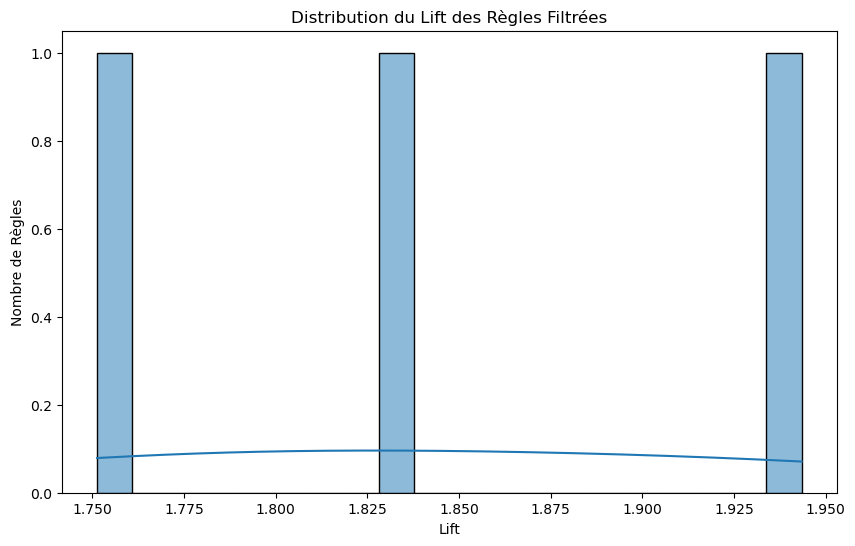

In [170]:
# Visualisation : distribution des métriques
plt.figure(figsize=(10, 6))
sns.histplot(top_rules['lift'], bins=20, kde=True)
plt.title('Distribution du Lift des Règles Filtrées')
plt.xlabel('Lift')
plt.ylabel('Nombre de Règles')
plt.show